# Bidirectional LSTM Classifier

In [3]:
# data analysis pkg
import pandas as pd
import matplotlib.pyplot as plt

# Word vectorization and splitting dataset
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Building sequential model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, SpatialDropout1D
from keras.layers import Embedding

# LSTM and Bidirectional Layers
from keras.layers import Bidirectional, LSTM

# Cofigurations
from keras.callbacks import ModelCheckpoint

# import metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score


# Avoiding warnings
import warnings
import os
########### Prevent Warnings ###########
warnings.filterwarnings(action='ignore')
########### Prevent Warnings ###########

# Read data

In [4]:
df = pd.read_csv('data/cleaned/data.csv')
df.title = df.title.astype('str')
df.text = df.text.astype('str')
df.comment = df.comment.astype('str')
df.rate = df.rate.astype('category')

# Setting features and Splitting dataset 

In [5]:
# features = df.columns.tolist()[:-1]
features = ['text']
label = ['verification_status']

X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[label], test_size=0.3)

X_train = [text for text in X_train.text]
Y_train = [label for label in Y_train.verification_status]

X_test = [text for text in X_test.text]
Y_test = [label for label in Y_test.verification_status]

## Set hypermeter

In [6]:
output_dir='model_output/bi_lstm/'

epochs = 4
batch_size = 128

n_dim = 64
n_unique_words = 5000
max_text_length = 500
pad_type = trunc_type = 'pre'
drop_embed = 0.2

n_lstm = 256
drop_lstm = 0.2

## Option 1 - Tokenizing and convert to sequences using keras tools

In [7]:
tok = Tokenizer(num_words=n_unique_words, lower=False)
tok.fit_on_texts(X_train)

train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_text_length)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_text_length)

## Option 2 - Tokenizing and convert to sequences using sklearn tools

In [7]:
# tfidf = TfidfVectorizer(use_idf=True, max_features=n_unique_words, tokenizer=word_tokenize)
# train_sequences_matrix = tfidf.fit_transform(X_train)
# test_sequences_matrix = tfidf.transform(X_test)

In [8]:
train_sequences_matrix.shape

(125369, 500)

# Designing Model Architecture

In [9]:
def BI_LSTM():
    model = Sequential()
    model.add(Embedding(n_unique_words, n_dim, input_length=max_text_length))
    model.add(SpatialDropout1D(drop_embed))
    model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [10]:
model = BI_LSTM()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 977,921
Trainable params: 977,921
Non-trainable params: 0
_________________________________________________________________


# Configure Model

In [11]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_ckpt = ModelCheckpoint(filepath=output_dir+'weights.{epoch:02d}.hdf5')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Train

In [12]:
model.fit(train_sequences_matrix, Y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1,
          validation_data=(test_sequences_matrix, Y_test), callbacks=[model_ckpt])

Train on 125369 samples, validate on 53730 samples
Epoch 1/4
125369/125369 [==============================] - 4121s 33ms/step - loss: 0.3125 - accuracy: 0.8846 - val_loss: 0.2730 - val_accuracy: 0.8999
Epoch 2/4
125369/125369 [==============================] - 4571s 36ms/step - loss: 0.2744 - accuracy: 0.8993 - val_loss: 0.2718 - val_accuracy: 0.9020
Epoch 3/4
125369/125369 [==============================] - 4057s 32ms/step - loss: 0.2617 - accuracy: 0.9047 - val_loss: 0.2722 - val_accuracy: 0.9003
Epoch 4/4
125369/125369 [==============================] - 4132s 33ms/step - loss: 0.2540 - accuracy: 0.9072 - val_loss: 0.2773 - val_accuracy: 0.9009


# Evaluate

In [13]:
model.load_weights(output_dir + 'weights.02.hdf5')

In [14]:
y_hat = model.predict_proba(test_sequences_matrix)

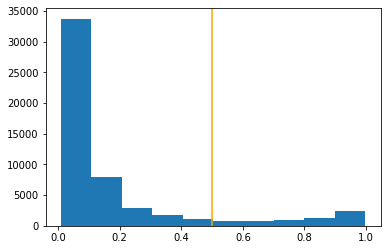

In [15]:
plt.hist(y_hat)
_ = plt.axvline(x=.5, color='orange')

In [16]:
auc = roc_auc_score(Y_test, y_hat)*100.0
print(auc)

88.0409931246579
